<a href="https://colab.research.google.com/github/mmmovania/CUDA_Spring_2024/blob/main/Week5/WaveformsMemoryBitmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-ai9qwms4
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-ai9qwms4
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [ ]:
%%cuda
#include <stdio.h>
#include <cuda.h>

const int WIDTH = 512;
const int HEIGHT = 512;
const int SIZE = WIDTH*HEIGHT;
const int IMAGE_SIZE_IN_BYTES = SIZE * sizeof(unsigned char)*4;

void load_raw_image(const char* imageName, unsigned char* pData)
{
	FILE* fp = fopen(imageName, "rb");
	if (fp)
	{
		fread(pData, 1, SIZE, fp);
		fclose(fp);
	}
	else
	{
		puts("Cannot open raw image.");
	}
}

void save_raw_image(const char* imageName, unsigned char* pData)
{
	FILE* fp = fopen(imageName, "wb");
	if (fp)
	{
		fwrite(pData, 4*sizeof(unsigned char), SIZE, fp);
		fclose(fp);
	}
	else
	{
		puts("Cannot write raw image.");
	}
}

__global__ void MakeImageKernel( unsigned char *ptr ) { 
	int x = threadIdx.x + blockIdx.x * blockDim.x;
	int y = threadIdx.y + blockIdx.y * blockDim.y;
	int offset = x + y * blockDim.x * gridDim.x;
	
	const float period = 256.0f;
	const float PI = 3.14159f;
	//float value = 255 * (sinf(x*2.0f*PI/ period) + 1.0f) * (sinf(y*2.0f*PI/ period) + 1.0f) / 4.0f;
	
	//sine wave
	//float value = 255 * sinf(x*2.0f*PI/period);

  float dx = x - 256;
	float dy = y - 256;
	//float value = 255 * sinf(sqrtf(dx*dx + dy*dy));

	float value = 255 * sinf(sqrtf(dx*dx + dy*dy)*2.0f*PI/ period);
	ptr[offset*4+0]=0;
	ptr[offset*4+1]=value;
	ptr[offset*4+2]=0;
	ptr[offset*4+3]=255;
}



int main(int argc, char** argv)
{ 
	unsigned char* host_bitmap = (unsigned char*)malloc(IMAGE_SIZE_IN_BYTES);
	unsigned char* dev_bitmap; 
	
	cudaMalloc(&dev_bitmap, IMAGE_SIZE_IN_BYTES); 
  
	dim3    blocksGrid;
	dim3    threadsBlock(16, 16, 1);
	blocksGrid.x = ceil(WIDTH / 16.0);
	blocksGrid.y = ceil(HEIGHT / 16.0);

	MakeImageKernel << <blocksGrid, threadsBlock >> >(dev_bitmap);

	cudaMemcpy(host_bitmap, dev_bitmap, IMAGE_SIZE_IN_BYTES, cudaMemcpyDeviceToHost);

	save_raw_image("/content/OutputImage.raw", host_bitmap);

	free(host_bitmap);
	cudaFree(&dev_bitmap); 
  cudaDeviceReset();
	return 0;
}

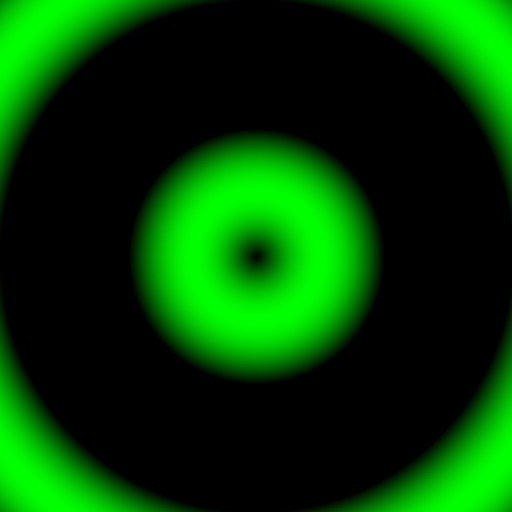

In [ ]:
import numpy as np

#lets view our image 
fd = open('/content/OutputImage.raw', 'rb')
rows = 512
cols = 512
f = np.fromfile(fd, dtype=np.uint8,count=rows*cols*4)
im = f.reshape((rows, cols, 4)) #notice row, column format
fd.close()

from google.colab.patches import cv2_imshow
#display image using cv2_imshow
cv2_imshow(im)